# Analysis of the housing market

* Cities: Amsterdam, Haarlem, Utrecht and Hilversum

* Ads with prices lower than 400 are excluded

* Ads with prices higher than 1250 are excluded

* Ads are scrapped from kamernet, pararius, huurwoningen.nl and huurstunt



In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
# from mpl_toolkits.basemap import Basemap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor

# 1. Preparing the data

## Pararius bug 1:

The Pararius scraper is scraping the wrong field for the 'type' column. This bug will be fixed in the future but I'll be dropping all Pararus entries from the dataframe for now. 

## Pararius bug 2:

I mispelled it as 'Parius'. (Not just here, but in the code as well. This might actually be a problem)


In [71]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
root_df = pd.read_csv('../input/ads.csv', parse_dates=['first_seen'])
df = root_df.copy()
df = df.drop(df[df.site == 'parius'].index)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2139 entries, 0 to 2735
Data columns (total 13 columns):
street                        2139 non-null object
city                          2139 non-null object
size                          2068 non-null float64
rooms                         1812 non-null float64
price                         2139 non-null float64
first_seen                    2139 non-null datetime64[ns]
site                          2139 non-null object
type                          2013 non-null object
open                          2139 non-null bool
distance_to_station           2139 non-null float64
travel_time_public_transit    2139 non-null float64
coordinates_lat               2139 non-null float64
coordinates_lon               2139 non-null float64
dtypes: bool(1), datetime64[ns](1), float64(7), object(4)
memory usage: 219.3+ KB


## Dealing with missing data.

The dataframe contains missing data. 

The 'Type' column is catagorical and the missing data will get its down dummy variable
The 'Size' column is numerical and will be imputed (using the median value)
The 'Rooms' column wont be used and will be dropped. (It has to many missing values for imputation)

In [73]:
for col in df.columns:
    print(f'{col} - {df[col].isnull().any()} - pct missing: {(df[col].isnull().sum(axis=0) / len(df)) * 100}')

street - False - pct missing: 0.0
city - False - pct missing: 0.0
size - True - pct missing: 3.319308087891538
rooms - True - pct missing: 15.287517531556801
price - False - pct missing: 0.0
first_seen - False - pct missing: 0.0
site - False - pct missing: 0.0
type - True - pct missing: 5.890603085553997
open - False - pct missing: 0.0
distance_to_station - False - pct missing: 0.0
travel_time_public_transit - False - pct missing: 0.0
coordinates_lat - False - pct missing: 0.0
coordinates_lon - False - pct missing: 0.0


In [74]:
df['size'].fillna(df['size'].median(), inplace=True)

## Dummy encoding catagorical variables

* Cities will be encoded as expected. 
* Types are a bit more complicated.

As can be seen in the chart below there are many different types, though most of them are simular and most values fall into a limited number of catagories. As such types will be re-encoded into the following categories:

- Kamer (Single room, shared kitchen and/ or bathroom)
- studio (Single room, but with kitchen / bathroom)
- Appartement (Multiple rooms, own kitchen / bathroom - multiple per building)
- Huis
- Unknown (Missing data)
- Other (mostly missing)

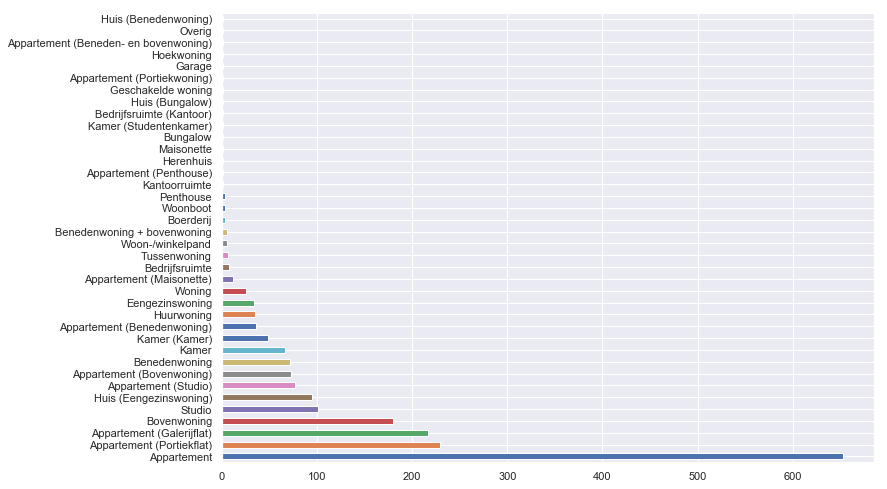

In [75]:
df['type'].value_counts().plot.barh()

### Dummy encode cities

In [76]:
df['city_old'] = df['city']
df = pd.get_dummies(
    df, columns=['city'], 
    prefix=['city']
)

### Re-encode types


In [77]:
def type_detector(x):
    if pd.isnull(x['type']):
        return 'unknown'

    if 'kamer' in x['type'].lower():
        return 'kamer'

    elif 'studio' in x['type'].lower():
        return 'studio'

    elif 'appartement' in x['type'].lower():
        # Check if the row has a 'rooms' value
        # So we can convert single room appartments to studios.
        if not pd.isnull(x['rooms']):
            if x['rooms'] == 1:
                return 'studio'
        return 'appartement'

    elif 'benedenwoning' in x['type'].lower():
        return 'appartement'

    elif 'bovenwoning' in x['type'].lower():
        return 'appartement'

    elif 'huis' in x['type'].lower():
        return 'huis'

    elif 'Eengezinswoning' in x['type'].lower():
        return 'huis'

    else:
        return 'other'
    


In [78]:
df['house_type'] = df.apply(type_detector, axis=1)

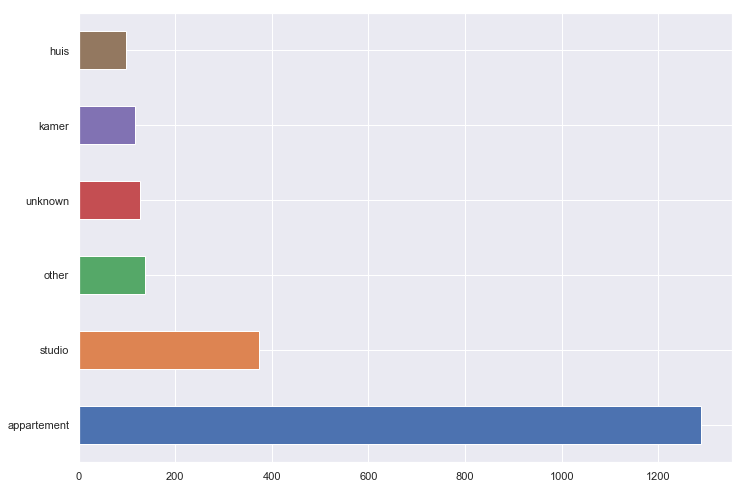

In [79]:
df['house_type'].value_counts().plot.barh()

## Recoding single room appartements to studios

Most of the ads listed seem to be appartments, but as the graph below shows many of them only have a single room and thus should be classified as 'Studio'. 

The following code should recode them to the correct type.


In [80]:
def studio_detector(x):
    if x['house_type'] == 'appartement':
        if x['rooms'] == 1:
            return 'studio'
    return x['house_type']

### Number of ads that should be classified as 'Studio' (but are regarded as appartements instead)

In [81]:
df.query('house_type == "appartement" & rooms == 1').shape[0]

40

### Type category counts before conversion

In [82]:
df['house_type'].value_counts()

appartement    1288
studio          373
other           137
unknown         126
kamer           117
huis             98
Name: house_type, dtype: int64

In [83]:
df['house_type'] = df.apply(studio_detector, axis=1)

### Type category counts after conversion

In [84]:
df['house_type'].value_counts()

appartement    1248
studio          413
other           137
unknown         126
kamer           117
huis             98
Name: house_type, dtype: int64

### Dummy encode new type values

In [85]:
df['type'] = df['house_type']
df = pd.get_dummies(
    df, columns=['house_type'], 
)

## Dealing with duplicate ads:

Since many ads appear on multiple sites the dataset contains a large number of duplicates. 
However, other ads are all part of a single large appertment building and, though simular in price / size and published on the same day are actually all distinct and valid. 

If the ads in the latter scenario are not published with unique appartment numbers they are currently considered to be duplicates. 
A future version of this analysis could mitigate this problem by using the URL of the ads to filter out false positives (though that would open its own can of worms)


Duplicates are currently filtered via the following process:

1. Its 'first_seen' value is transformed from a datetime to a date. (Dropping the hours and minutes) - ads are published by day - not per second. 

2. Ads are compared on the 'street', 'size', 'price', 'type' and 'city_old' variables. If duplicates are found only the first entry is kept.


In [86]:
df['first_seen'] = df['first_seen'].dt.date

### All ads marked as 'True' will be deleted, its a substantial ammount.

In [87]:
df.duplicated(['street', 'size', 'price', 'type', 'city_old'], keep='first').value_counts()

False    1701
True      438
dtype: int64

In [113]:
df.drop_duplicates(['street', 'size', 'price', 'type', 'city_old'], keep='first', inplace=True)

# 2. Data analysis - descriptive statistics

## Number of ads, per city

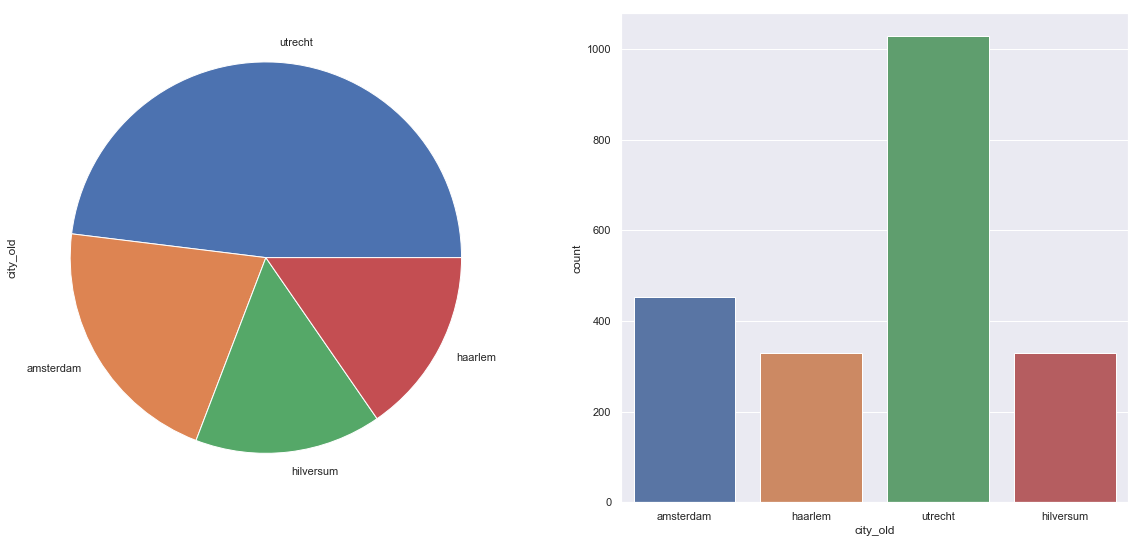

In [89]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 9))
df['city_old'].value_counts().plot.pie(ax=axes[0])
sns.countplot('city_old', data=df, ax=axes[1])

## Number of ads, per type

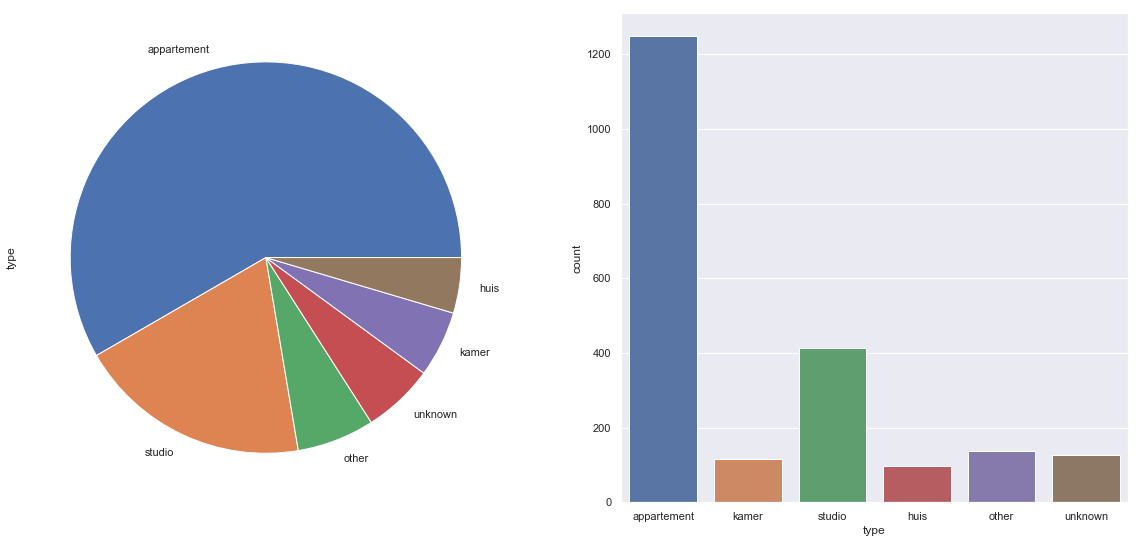

In [90]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 9))
df['type'].value_counts().plot.pie(ax=axes[0])
sns.countplot('type', data=df, ax=axes[1])

## Number of ads, per type per city

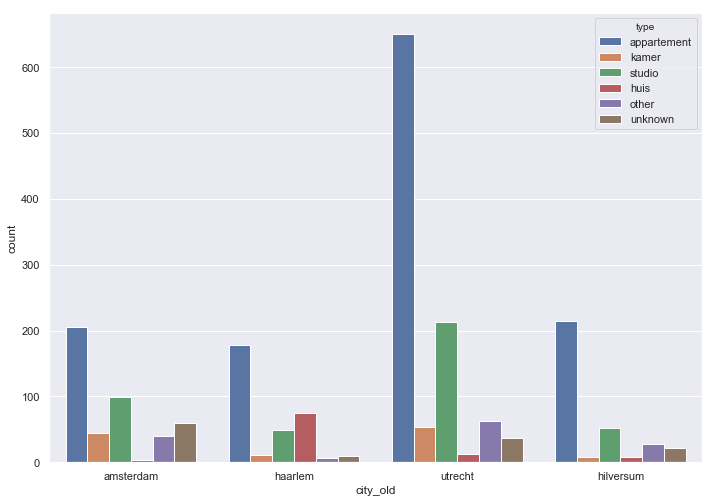

In [91]:
sns.countplot('city_old', hue=df['type'], data=df)

## Type / Size per city - as table

In [92]:
df.groupby(['type', 'city_old'])['size'].describe()

count        mean        std   min    25%    50%  \
type        city_old                                                      
appartement amsterdam  206.0   57.878641  26.743220   0.0  37.75   55.5   
            haarlem    178.0   54.926966  17.997183   0.0  45.00   50.0   
            hilversum  214.0   66.677570  85.146015   0.0  42.00   59.0   
            utrecht    650.0   59.503077  28.477182   0.0  40.00   55.0   
huis        amsterdam    3.0   76.666667  40.414519  30.0  65.00  100.0   
            haarlem     75.0   50.013333   7.881716   0.0  50.00   50.0   
            hilversum    8.0  101.125000  40.923055  65.0  80.00   90.0   
            utrecht     12.0  108.500000  32.497552  34.0  88.75  111.5   
kamer       amsterdam   45.0   23.177778  18.477614   5.0  12.00   18.0   
            haarlem     11.0   30.545455  19.821017  14.0  17.50   24.0   
            hilversum    8.0   18.625000   5.578978  15.0  15.00   15.0   
            utrecht     53.0   25.811321  20.798536   0.0  15.00   18.0   
other       amsterdam   40.0   70.675000  32.094722   0.0  41.75   70.0   
            haarlem      7.0   69.571429  31.405186  40.0  43.00   60.0   
            hilversum   27.0   67.185185  27.336981   0.0  45.00   80.0   
            utrecht     63.0   85.460317  48.467424  15.0  40.00   85.0   
studio      amsterdam   99.0   37.939394  21.922786   0.0  29.00   32.0   
            haarlem     49.0   36.693878  10.563704  22.0  28.00   35.0   
            hilversum   52.0   33.461538  17.528086   1.0  22.00   34.5   
            utrecht    213.0   34.436620  18.771767   0.0  25.00   30.0   
unknown     amsterdam   59.0   84.847458  20.627913  37.0  76.50   87.0   
            haarlem      9.0   43.444444  42.761288   0.0   0.00   27.0   
            hilversum   21.0   24.190476  67.932039   0.0   0.00    0.0   
            utrecht     37.0   21.405405  26.084754   0.0   0.00    0.0   

                          75%     max  
type        city_old                   
appartement amsterdam   75.00   145.0  
            haarlem     63.00   120.0  
            hilversum   70.00  1000.0  
            utrecht     71.00   370.0  
huis        amsterdam  100.00   100.0  
            haarlem     50.00    77.0  
            hilversum  101.75   197.0  
            utrecht    137.25   145.0  
kamer       amsterdam   28.00    94.0  
            haarlem     37.50    80.0  
            hilversum   22.00    30.0  
            utrecht     32.00   118.0  
other       amsterdam   94.00   150.0  
            haarlem     95.00   111.0  
            hilversum   87.50   107.0  
            utrecht    121.50   248.0  
studio      amsterdam   40.00   145.0  
            haarlem     42.00    68.0  
            hilversum   40.00   124.0  
            utrecht     40.00   176.0  
unknown     amsterdam   98.00   130.0  
            haarlem     94.00    95.0  
            hilversum    0.00   300.0  
            utrecht     46.00    75.0

## Type / Price per city - as table

In [93]:
df.groupby(['type', 'city_old'])['price'].describe()

count         mean         std     min      25%  \
type        city_old                                                     
appartement amsterdam  206.0  1045.475728  200.535276     0.0   917.00   
            haarlem    178.0  1094.988764  146.376073   425.0  1000.00   
            hilversum  214.0   947.219626  200.753518   475.0   825.00   
            utrecht    650.0  1034.523077  155.129113   416.0   926.25   
huis        amsterdam    3.0  1166.666667   57.735027  1100.0  1150.00   
            haarlem     75.0   935.133333   64.346892   835.0   905.00   
            hilversum    8.0  1123.750000  139.149201   850.0  1073.75   
            utrecht     12.0  1152.416667   77.466073  1020.0  1106.25   
kamer       amsterdam   45.0   731.200000  142.220475   450.0   650.00   
            haarlem     11.0   565.909091  102.635719   475.0   500.00   
            hilversum    8.0   487.375000   73.071271   400.0   437.50   
            utrecht     53.0   584.433962  165.502325   400.0   455.00   
other       amsterdam   40.0   958.825000  231.984072   419.0   848.50   
            haarlem      7.0  1039.571429  298.793606   400.0  1013.50   
            hilversum   27.0  1002.592593  209.460710   525.0   837.50   
            utrecht     63.0  1003.317460  215.841999   500.0   920.00   
studio      amsterdam   99.0  1054.535354  169.556343   500.0   950.00   
            haarlem     49.0   965.632653  188.936794   550.0   865.00   
            hilversum   52.0   739.423077  177.144158   430.0   621.25   
            utrecht    213.0   854.131455  180.662856   491.0   725.00   
unknown     amsterdam   59.0  1110.915254   98.810737   899.0  1055.00   
            haarlem      9.0   978.666667  183.584449   600.0   935.00   
            hilversum   21.0  1022.380952  155.552395   700.0   895.00   
            utrecht     37.0   978.081081  230.514326   500.0   750.00   

                          50%      75%     max  
type        city_old                            
appartement amsterdam  1095.0  1200.00  1250.0  
            haarlem    1150.0  1200.00  1250.0  
            hilversum   975.0  1100.00  1250.0  
            utrecht    1050.0  1165.00  1250.0  
huis        amsterdam  1200.0  1200.00  1200.0  
            haarlem     940.0   940.00  1250.0  
            hilversum  1172.5  1212.50  1250.0  
            utrecht    1177.5  1196.25  1250.0  
kamer       amsterdam   700.0   850.00   975.0  
            haarlem     525.0   562.50   800.0  
            hilversum   487.5   531.00   600.0  
            utrecht     550.0   600.00  1000.0  
other       amsterdam  1000.0  1131.25  1250.0  
            haarlem    1175.0  1212.50  1250.0  
            hilversum   995.0  1200.00  1250.0  
            utrecht    1034.0  1175.00  1250.0  
studio      amsterdam  1100.0  1200.00  1250.0  
            haarlem     965.0  1150.00  1250.0  
            hilversum   725.0   830.00  1250.0  
            utrecht     845.0   975.00  1250.0  
unknown     amsterdam  1100.0  1193.00  1250.0  
            haarlem    1018.0  1048.00  1250.0  
            hilversum  1025.0  1150.00  1250.0  
            utrecht    1050.0  1150.00  1250.0

## Price / Size per city - as charts

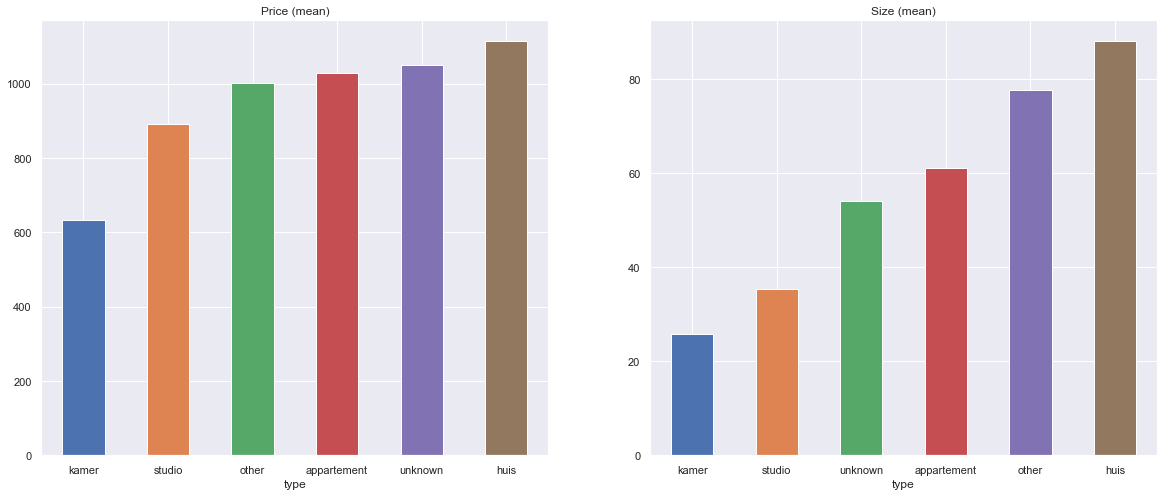

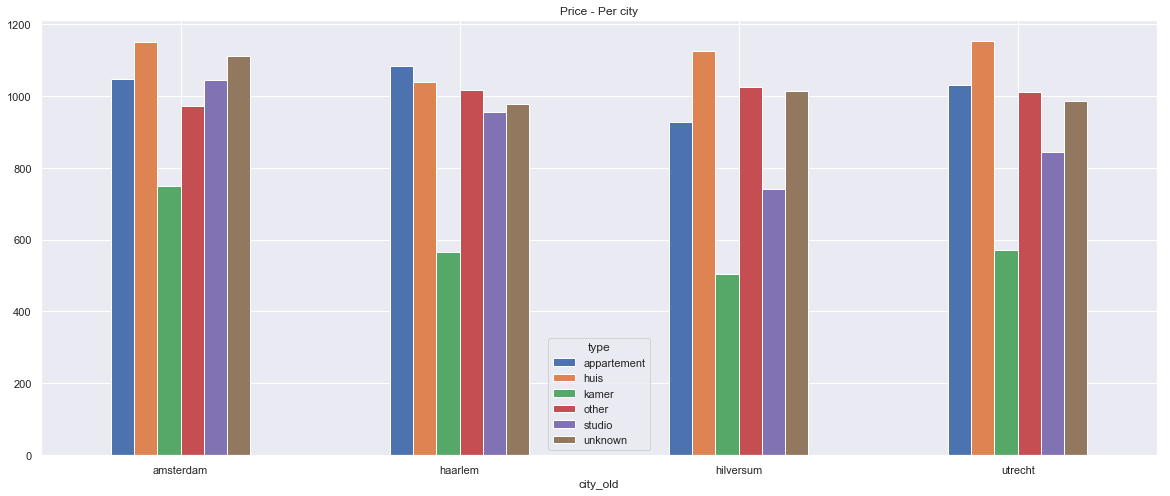

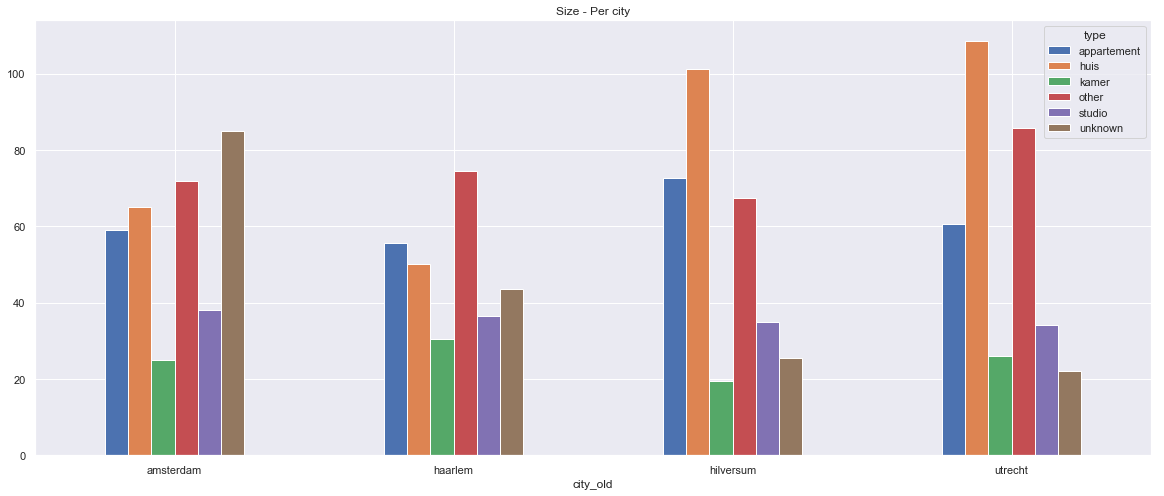

In [145]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
df.groupby('type')['price'].mean().sort_values(ascending=True).plot.bar(rot=0, ax=axes[0], title='Price (mean)')
df.groupby('type')['size'].mean().sort_values(ascending=True).plot.bar(rot=0, ax=axes[1], title='Size (mean)')
df.groupby(['city_old', 'type'])['price'].mean().unstack().plot.bar(rot=0, figsize=(20,8), title='Price - Per city')
df.groupby(['city_old', 'type'])['size'].mean().unstack().plot.bar(rot=0, figsize=(20,8), title='Size - Per city')

## Price / Size histograms

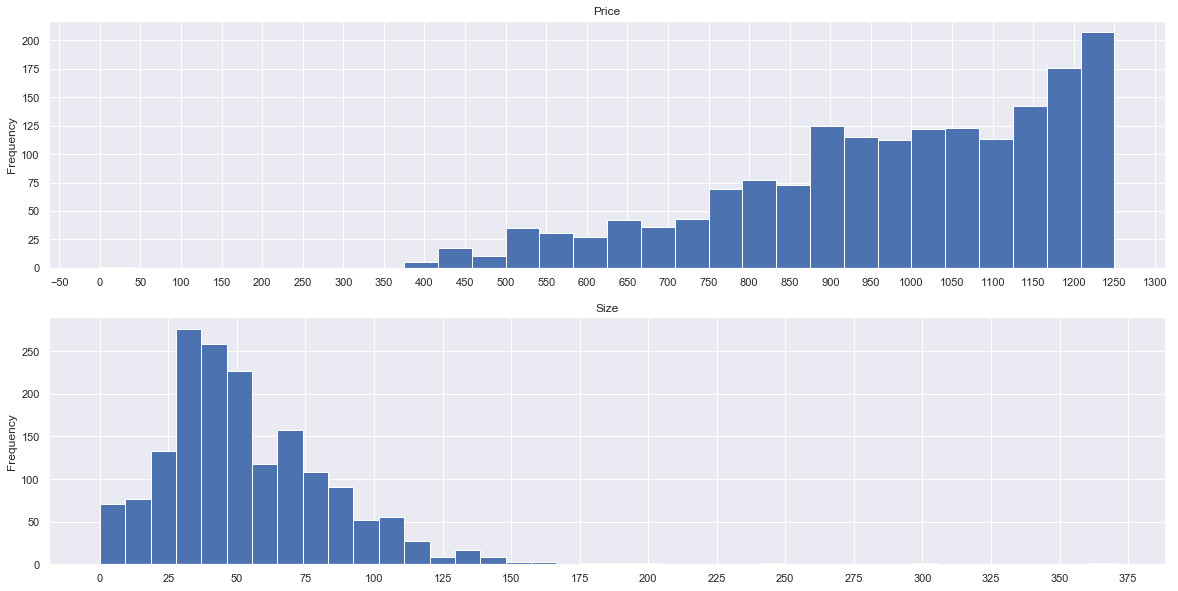

In [140]:
import matplotlib.ticker as plticker
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(20,10))
loc = plticker.MultipleLocator(base=50.0)
df['price'].plot.hist(ax=axes[0], bins=30, title='Price').xaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=25.0)
df[df['size'] < 500]['size'].plot.hist(ax=axes[1], bins=40, title='Size').xaxis.set_major_locator(loc)

## Price / Size boxplots

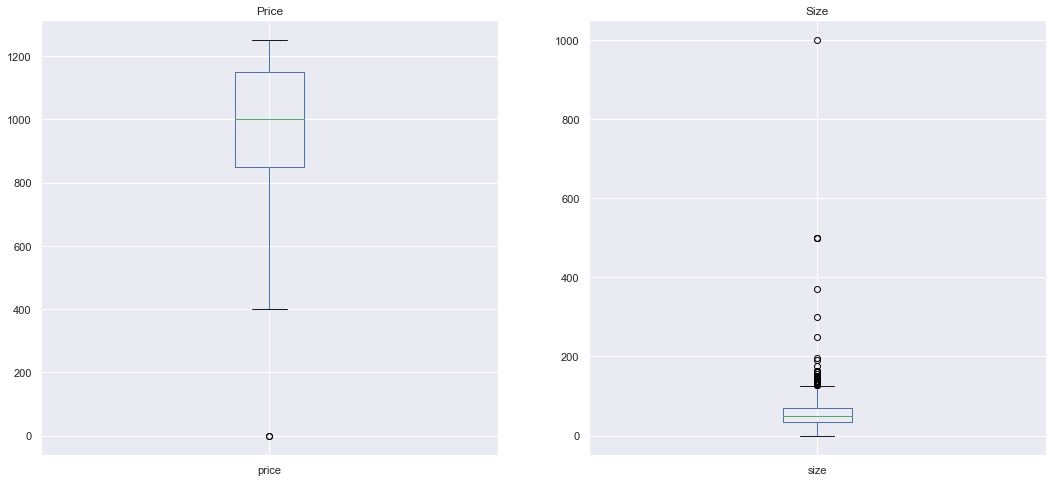

In [96]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 8))
df['price'].plot.box(ax=axes[0], title='Price')
df['size'].plot.box(ax=axes[1], title='Size')

## Price / Size scatterplots

These graphs are severly distorted by various outliers, the graph below excludes them showing that the expected positive correlation does exist.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


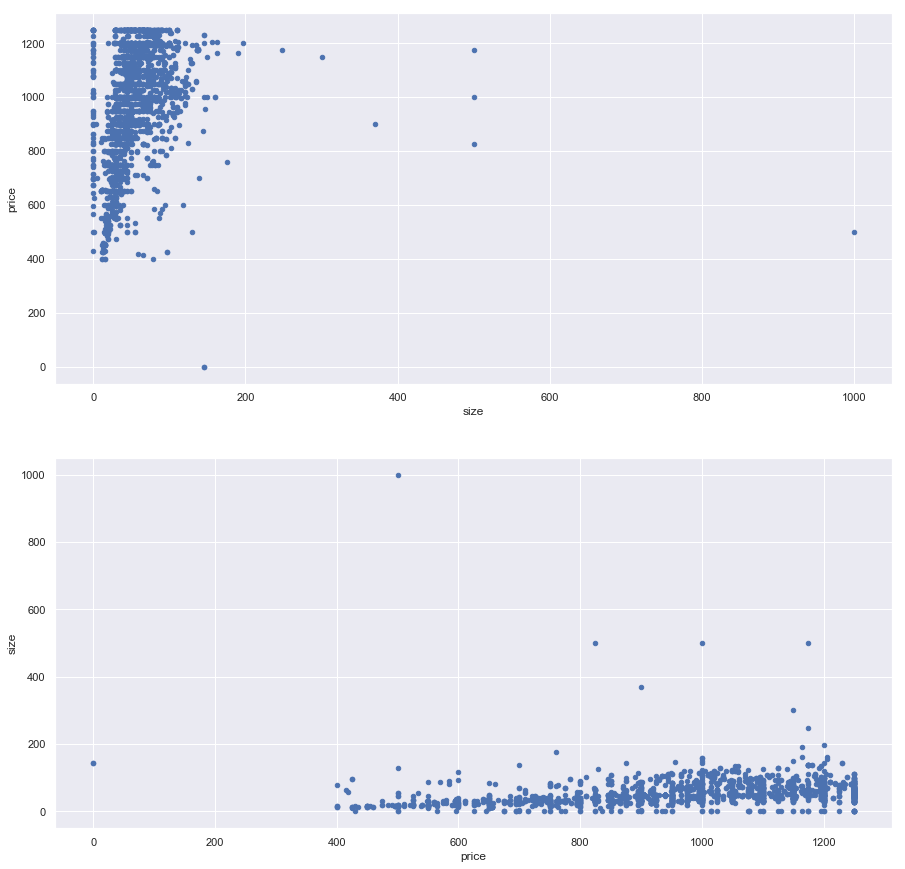

In [97]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15,15))
df.plot.scatter('size', 'price', ax=axes[0])
df.plot.scatter('price', 'size', ax=axes[1])

## Price / Size scatterplots, excluding outliers

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


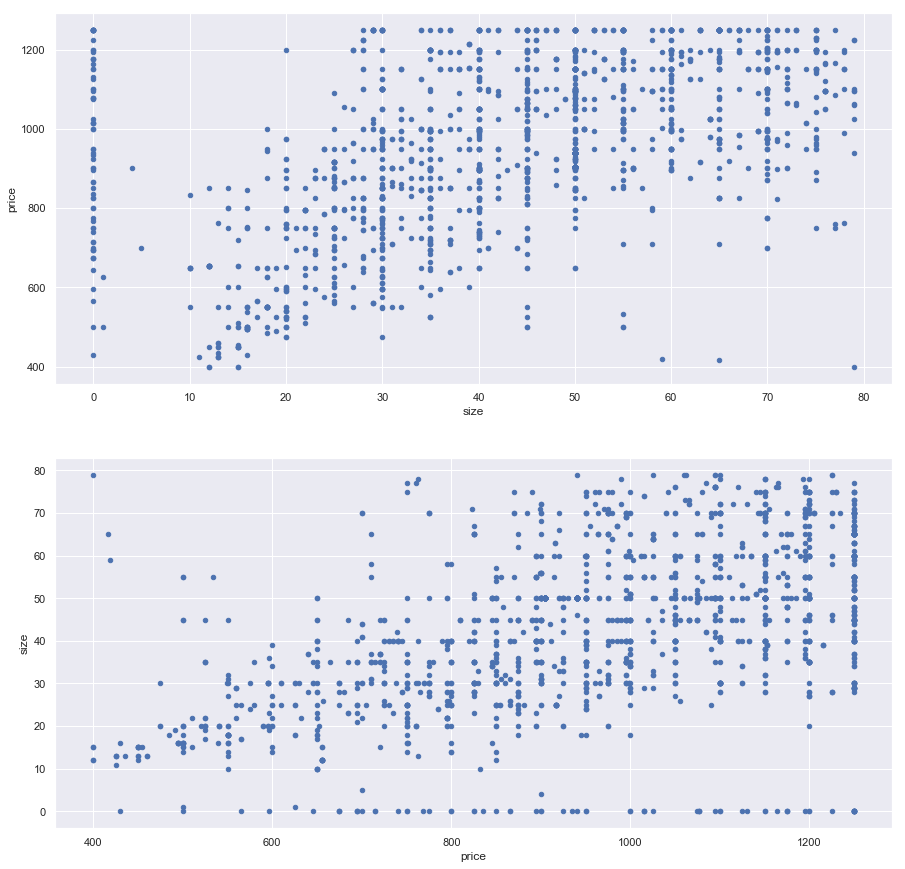

In [98]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15,15))
df[df['size'] < 80].plot.scatter('size', 'price', ax=axes[0])
df[df['size'] < 80].plot.scatter('price', 'size', ax=axes[1])

## Distance and traveltime histograms

Both 

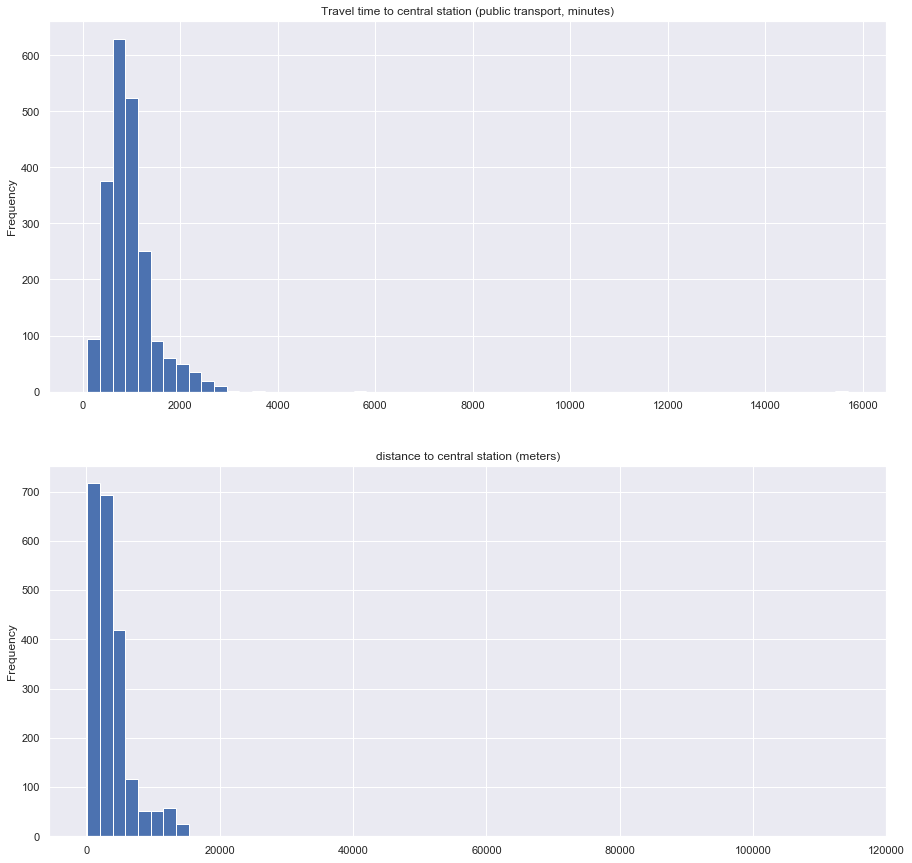

In [99]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15,15))
df['travel_time_public_transit'].plot.hist(
    bins=60, ax=axes[0], title='Travel time to central station (public transport, minutes)')
df['distance_to_station'].plot.hist(
    bins=60, ax=axes[1], title='distance to central station (meters)')

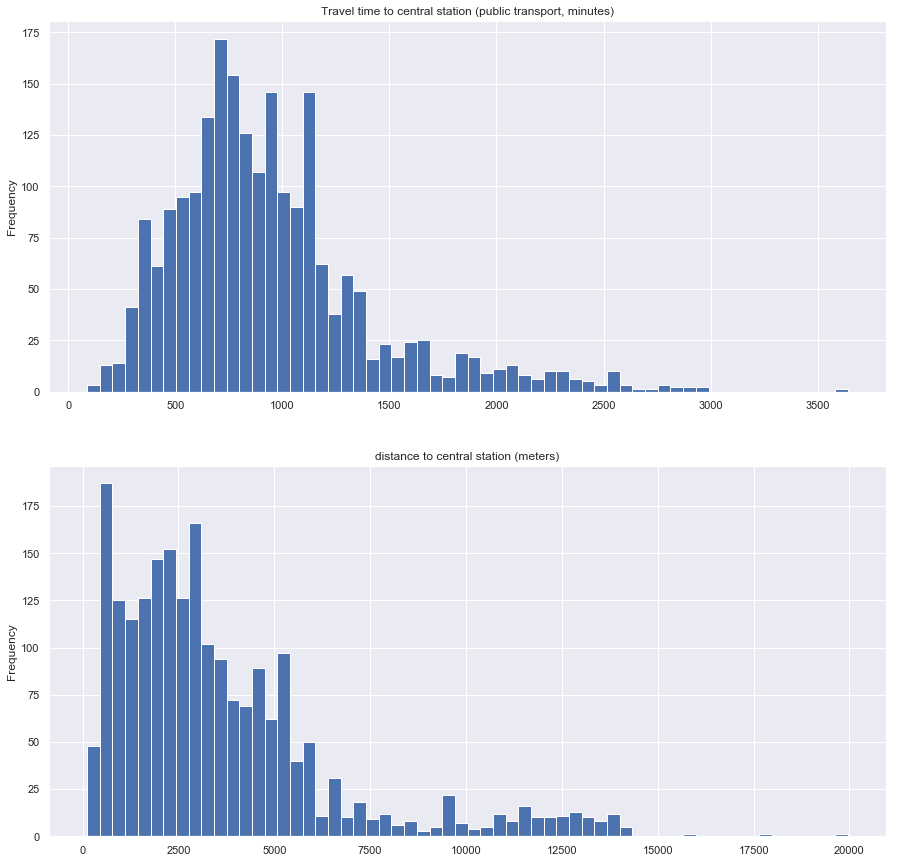

In [100]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15,15))
df[df['travel_time_public_transit'] < 4000]['travel_time_public_transit'].plot.hist(
    bins=60, ax=axes[0], title='Travel time to central station (public transport, minutes)')
df[df['distance_to_station'] < 20000]['distance_to_station'].plot.hist(
    bins=60, ax=axes[1], title='distance to central station (meters)')

## Distance and traveltime scatter

* The relation seems to be as linear as expected, but the peculiar ramp in the beginning might indicate some sort of anomaly. 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


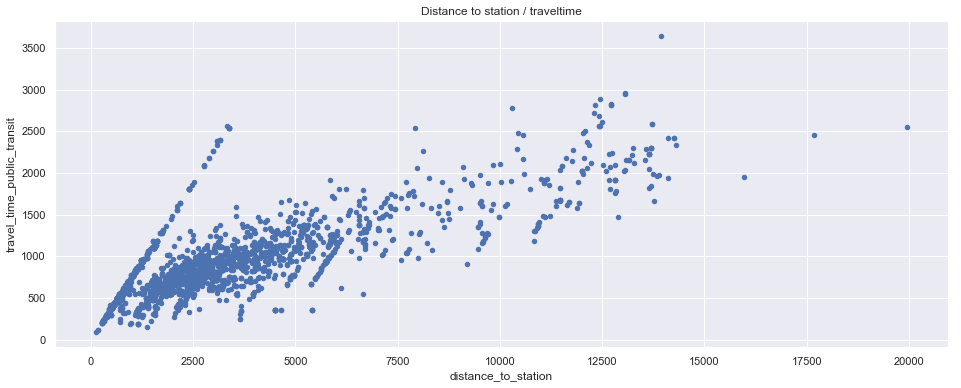

In [101]:
df[df['distance_to_station'] < 20000].plot.scatter(
    'distance_to_station', 'travel_time_public_transit',
    title='Distance to station / traveltime', figsize=(16,6))

## Distance / Traveltime vs Price scatters

At best, the pricecap of 1250 distorts these graphs enough to hide any (linear) relation.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


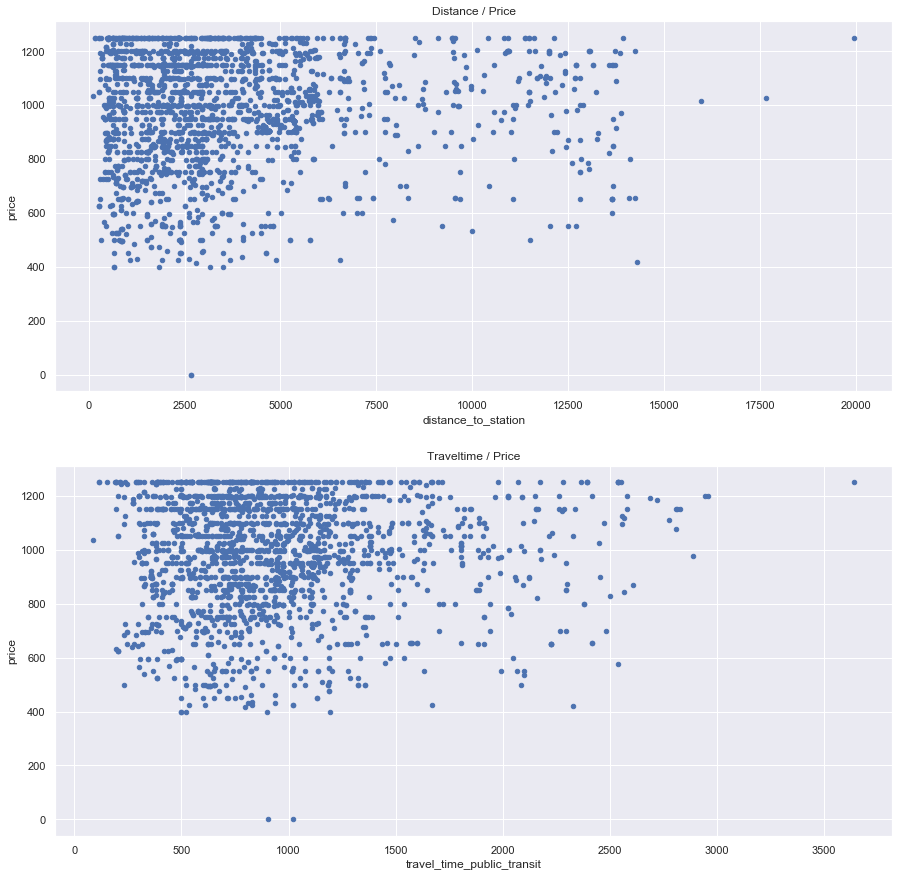

In [102]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15,15))
df[df['distance_to_station'] < 20000].plot.scatter(
    'distance_to_station', 'price',
    title='Distance / Price', ax=axes[0])

df[df['distance_to_station'] < 20000].plot.scatter(
    'travel_time_public_transit', 'price',
    title='Traveltime / Price', ax=axes[1])

## Geoplot - cities / price

* Hilversum seems to be affected by some outliers

Todo - plot over actual map

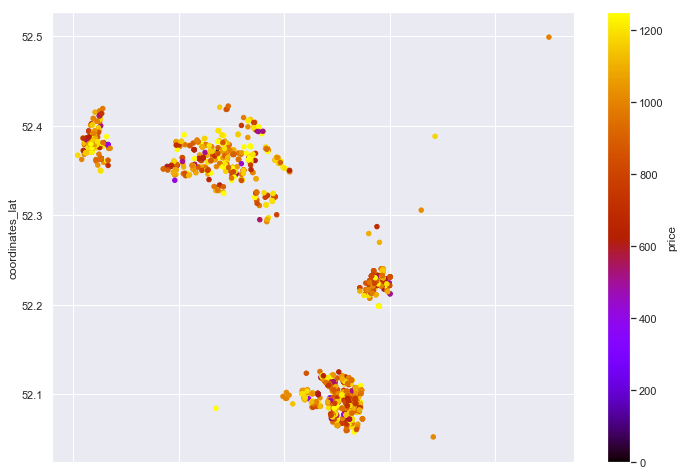

In [103]:
df.plot.scatter(x='coordinates_lon', y='coordinates_lat', c='price', cmap='gnuplot')

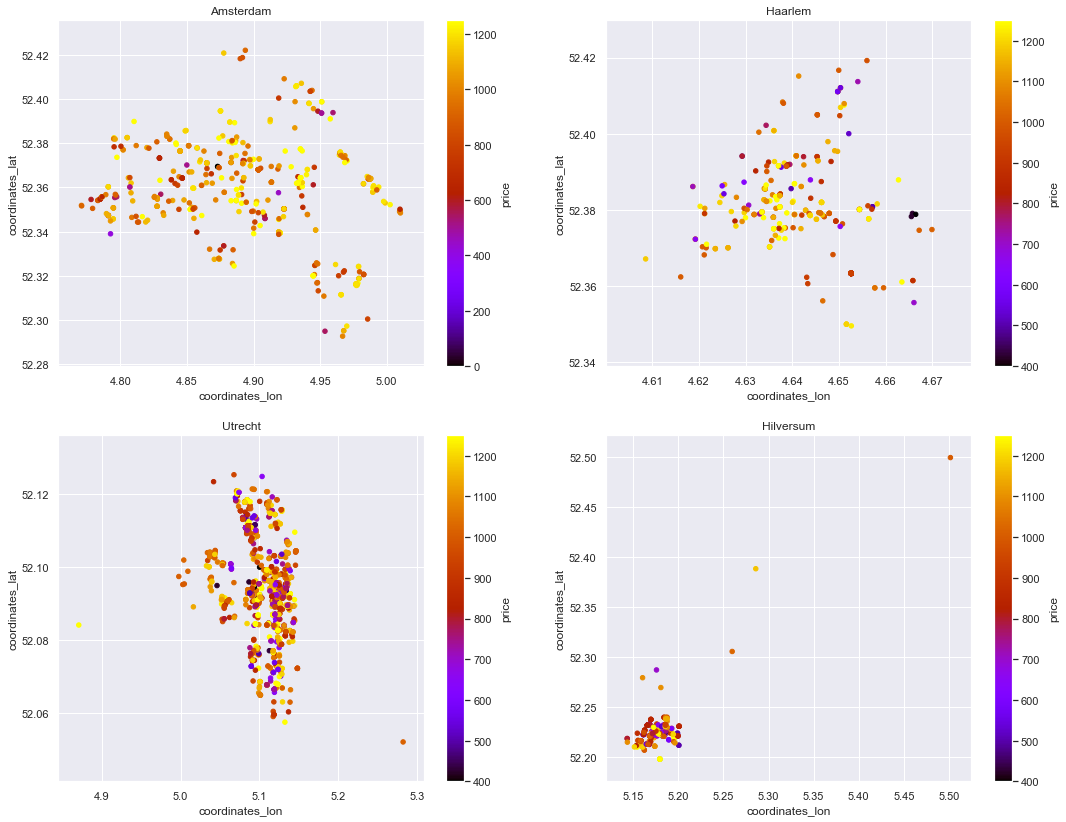

In [104]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 14))
df[df['city_amsterdam']==1].plot.scatter(
    x='coordinates_lon', y='coordinates_lat', c='price',
    cmap='gnuplot', ax=axes[0, 0], title='Amsterdam')
df[df['city_haarlem']==1].plot.scatter(
    x='coordinates_lon', y='coordinates_lat', c='price',
    cmap='gnuplot', ax=axes[0, 1], title='Haarlem')
df[df['city_utrecht']==1].plot.scatter(
    x='coordinates_lon', y='coordinates_lat', c='price',
    cmap='gnuplot', ax=axes[1, 0], title='Utrecht')
df[df['city_hilversum']==1].plot.scatter(
    x='coordinates_lon', y='coordinates_lat', c='price',
    cmap='gnuplot', ax=axes[1, 1], title='Hilversum')

## Correlation matrix (pearons r / price)

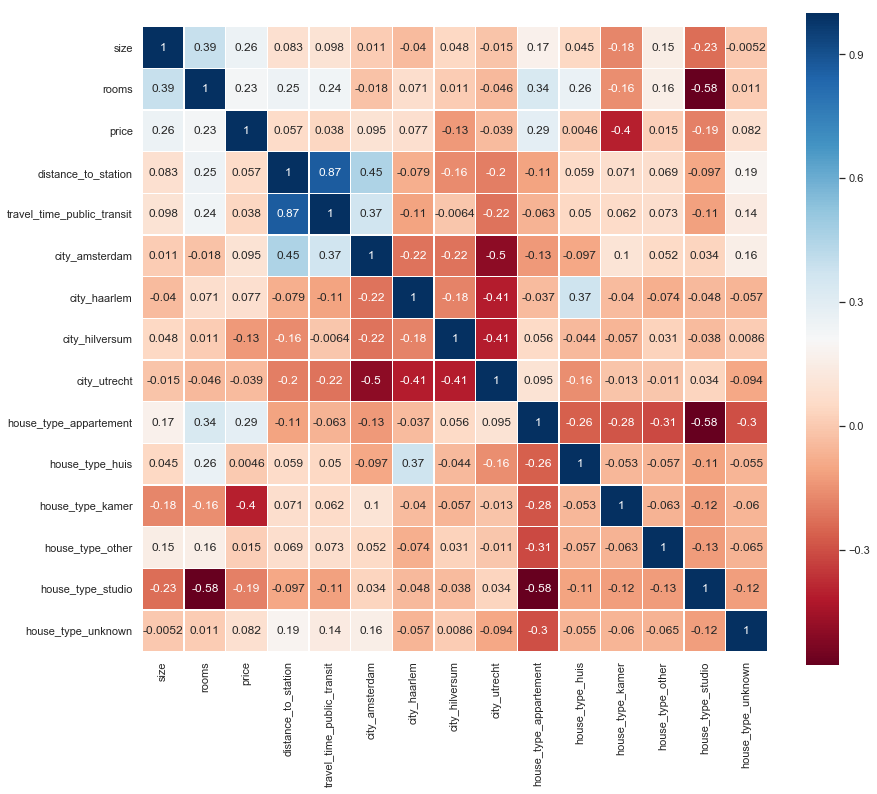

In [105]:
plt.figure(figsize=(14,12))
sns.heatmap(df[
    list(df.drop(['open', 'coordinates_lat', 'coordinates_lon'], axis=1))
].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=plt.cm.RdBu, linecolor='white', annot=True)

## Correlation (pearons r / met prijs), strenght and direction

(array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4]),
 <a list of 10 Text xticklabel objects>)

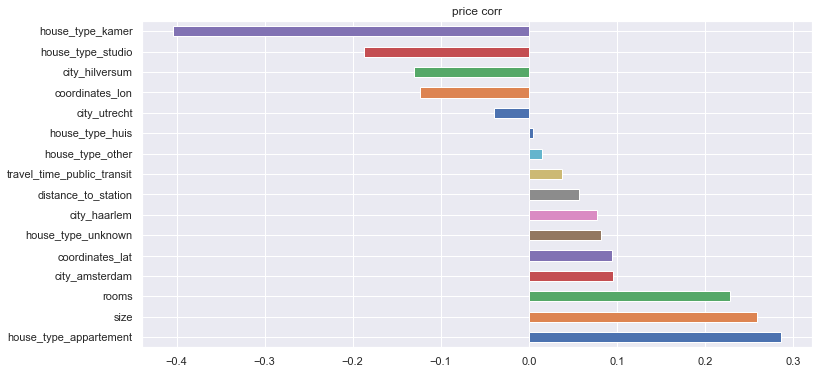

In [106]:
df.corr()['price'].drop(['price', 'open']).sort_values(ascending=False).plot.barh(figsize=(12,6), title='price corr')
plt.xticks(rotation=0)

# 3. Data analysis- inferential statistics

This section contains various statistical and machine-learning models to both investigate the effect of various parameters on the price and predict the expected price for the 'Change=' appartment in Amsterdam Zuidoost

The function below is used to predict the price based on the OLS models.

In [107]:
def predictor(size, type='studio', city='amsterdam', model=None, intercept=True):
    if not model:
        raise ValueError('Model not set!')
    size_slope = model.params['size']
    if city:
        city_slope = model.params['city_' + city.lower()]
    else: 
        city_slope = 0
    type_slope = model.params['house_type_' + type.lower()]
    if intercept:
        intercept = model.params['const']
    else: 
        intercept = 0

    price = intercept + (size * size_slope) + city_slope + type_slope
    return price

## OLS regression, with price as dependent variable

* 'Utrecht' is used as the baseline for cities
* 'Other' is used as the baselien for type

Most parameters register as statistically significant. 
The Adj. R-squared of 0.29 allows for plenty of variation though

In [108]:
cols = [
    'size', 'city_amsterdam', 'city_haarlem', 'city_utrecht', 
    'house_type_appartement',
    'house_type_huis', 'house_type_kamer', 'house_type_studio',
]
model = sm.OLS(df['price'], sm.add_constant(df[cols])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     107.3
Date:                Mon, 18 Mar 2019   Prob (F-statistic):          1.31e-150
Time:                        18:35:59   Log-Likelihood:                -14076.
No. Observations:                2139   AIC:                         2.817e+04
Df Residuals:                    2130   BIC:                         2.822e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    880

## Change= (825 p/m) predicted price:

* Studio
* Amsterdam
* 30m2

The output seems to suggest that change= is relativly cheap - but we must consider that the model account for only +/- a third of all variation

In [109]:
predictor(30, type='studio', model=model, city='Amsterdam')

951.892983466147

# Haarlemsche-Poort predicted price:

In [110]:
predictor(85, type='appartement', model=model, city='Haarlem')

1092.9956896095252

## OLS regression, with price as dependent variable, with both traveltime and distance included. 

* 'Utrecht' is used as the baseline for cities
* 'Other' is used as the baselien for type

Neither of the new variables is statistically significant. 

In [111]:
df.fillna(df.median, inplace=True)
df['travel_time_public_transit'] = df['travel_time_public_transit'] / 60
df['distance_to_station'] = df['distance_to_station'] / 1000

In [112]:
cols = [
    'size', 'city_amsterdam', 'city_haarlem', 'city_utrecht', 
    'house_type_appartement', 'house_type_huis', 'house_type_kamer', 
    'house_type_studio', 'distance_to_station', 'travel_time_public_transit',

]
model = sm.OLS(df['price'], sm.add_constant(df[cols])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     85.79
Date:                Mon, 18 Mar 2019   Prob (F-statistic):          1.12e-148
Time:                        18:36:14   Log-Likelihood:                -14076.
No. Observations:                2139   AIC:                         2.817e+04
Df Residuals:                    2128   BIC:                         2.824e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

# Machine learning models

It seems strange to me that neither the 'distance to station' and 'travel_time_public_transit' variables register as significant predictors. It is possible however that their relationship with price is non-linear. (As I presume to be the case for the lat/lon coordiantes as well)

The following section contains 2 more advanced machine learning models to test this hypothesis.

1. A linear models with polynomials
2. A gradient Boosting model

Both models will be rated with the following parameters:
* R2
* MSE
* MSE LOG

As a bonus I will also compare their predictions for the 'Change=' appartment (as encoding below)

### Change=, encoded as a python dictionary

In [121]:
change = { 
    'size': [30], 'distance_to_station': 11052, 'travel_time_public_transit': 1177, 
    'coordinates_lat': 52.316280, 'coordinates_lon': 4.952778, 
    'city_amsterdam': [1], 'city_haarlem': [0], 'city_hilversum': [0],
    'city_utrecht': [0], 'house_type_appartement': [0], 
    'house_type_huis': [0], 'house_type_kamer': [0], 'house_type_other': [0],
    'house_type_studio':[1] , 'house_type_unknown': [0],
   
}
change_df = pd.DataFrame.from_dict(change)

### Haarlemsche-Poort, encoded as a python dictionary

In [122]:
hp = { 
    'size': [85], 'distance_to_station': 2800, 'travel_time_public_transit': 1140, 
    'coordinates_lat': 52.369716, 'coordinates_lon': 4.652807, 
    'city_amsterdam': [0], 'city_haarlem': [1], 'city_hilversum': [0],
    'city_utrecht': [0], 'house_type_appartement': [1], 
    'house_type_huis': [0], 'house_type_kamer': [0], 'house_type_other': [0],
    'house_type_studio':[0] , 'house_type_unknown': [0],
   
}
hp_df = pd.DataFrame.from_dict(hp)

## Scoring function

In [118]:
def print_report(model, best_params=True):
    if best_params:
        print('BEST PARAMS:\n')
        print(
            'Model: '+ str(model.best_params_)
        )
    print('\n\nACCURACY SCORES:\n')
    print(
        'R2: ' + str(r2_score(y_test, model.predict(X_test)))
    )
    print(
        'MSE: ' + str(mean_squared_error(y_test, model.predict(X_test)))
    )
    try:
        print(
            'MSE_LOG: ' + str(mean_squared_log_error(y_test, model.predict(X_test)))
        ) 
    except:
        print('MSE_LOG: ERROR')
    

## Split data in train / test sets

In [115]:
sk_df = df.drop(['street', 'type', 'first_seen', 'site', 'open', 'city_old', 'rooms'], axis=1)
X = sk_df.drop('price', axis=1)
y = sk_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Linear model with polynomial features

* This model scores resemble the simpler OLS model - however its prediction is significantly worse. 

In [136]:
%%time
%%capture [--no-stdout]

pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(2)),
    ('reg', LinearRegression()),
    ]
)

params = { 
    'poly__degree': [0, 1,2, 3],
}


reg_clf = GridSearchCV(
    pipe, param_grid=params, cv=10, n_jobs=-1
)

reg_clf.fit(X_train, y_train)

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 5.37 s


### Score:

In [137]:
print_report(reg_clf)

BEST PARAMS:

Model: {'poly__degree': 1}


ACCURACY SCORES:

R2: 0.3256892228766334
MSE: 30075.397906103884
MSE_LOG: 0.03898268412332496


### Change= prediction:

In [138]:
reg_clf.predict(change_df)

array([-10823.39019967])

### Haarlemsche-Poort prediction:

In [132]:
reg_clf.predict(hp_df)

array([-920.08649506])

## Gradient Boosting model

* This model scores much better, however, its prediction is simular to the ones made by the simpler the OLS model.

In [46]:
%%time
%%capture [--no-stdout]

pipe = Pipeline(steps=[
    ('feature', None),
    ('pre', None),
    ('poly', PolynomialFeatures(2)),
    ('pca', None),
    ('reg', XGBRegressor()),
    ]
)

params = { 
    'pre': [
        None, StandardScaler(), MinMaxScaler(),
    ],
    'pca': [None, PCA(n_components=0.95), PCA(n_components=0.75)],
    'poly__degree': [1,2, 3],
    'reg__max_depth': [3, 5, 7],
}


xgb_clf = GridSearchCV(
    pipe, param_grid=params, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
)

xgb_clf.fit(X_train, y_train)

CPU times: user 5.77 s, sys: 248 ms, total: 6.02 s
Wall time: 9min 36s


### Score:

In [47]:
print_report(xgb_clf)

BEST PARAMS:

Model: {'pca': None, 'poly__degree': 1, 'pre': MinMaxScaler(copy=True, feature_range=(0, 1)), 'reg__max_depth': 5}


ACCURACY SCORES:

R2: 0.5579972811315264
MSE: 19514.7697346883
MSE_LOG: 0.026279360279985443


### Change= prediction:

In [48]:
xgb_clf.predict(change_df)

array([1074.7803], dtype=float32)

### Haarlemsche-Poort prediction:

In [49]:
xgb_clf.predict(hp_df)

array([979.15283], dtype=float32)